## Modelling:

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
import pandas as pd
import numpy as np
df_trans = pd.read_csv('/content/drive/MyDrive/NeoStats_Keerthana/Transaction Data.csv')
df_cust = pd.read_csv('/content/drive/MyDrive/NeoStats_Keerthana/Customer Data.csv')

### Handling of Null Values and Imbalance in Target Data

*Firstly we join both the datasets based on the Column 'Customer Number'*

In [123]:
df = pd.merge(df_trans, df_cust, on='Customer_number', how='inner')

df = df[['Sno', 'Customer_number', 'Insurance', 'balance', 'housing', 'loan',
         'contact', 'duration', 'campaign', 'last_contact_day', 'previous',
         'poutcome', 'Term Deposit', 'Count_Txn', 'age', 'job', 'marital',
         'education', 'Annual Income', 'Gender']]
df.head()

,Sno,Customer_number,Insurance,balance,housing,loan,contact,duration,campaign,last_contact_day,previous,poutcome,Term Deposit,Count_Txn,age,job,marital,education,Annual Income,Gender
0,0,1001,no,2143.0,yes,no,NaN,261.0,1,2,0,NaN,no,351.0,58.0,management,married,tertiary,839368.0,M
1,1,1002,no,29.0,yes,no,NaN,151.0,1,2,0,NaN,no,326.0,44.0,technician,single,secondary,1452858.0,M
2,2,1003,no,2.0,yes,yes,NaN,76.0,1,2,0,NaN,no,422.0,33.0,entrepreneur,married,NaN,4851383.0,F
3,3,1004,no,1506.0,yes,no,NaN,92.0,1,2,0,NaN,no,113.0,47.0,blue-collar,married,NaN,3207754.0,F
4,4,1005,no,1.0,no,no,NaN,198.0,1,2,0,NaN,no,342.0,33.0,NaN,single,NaN,2562322.0,M


*Before we move on the modelling stage we will be handling the missing values.*

In [124]:
df.isna().sum()

Sno                     0
Customer_number         0
Insurance               0
balance                86
housing                 0
loan                    8
contact             13030
duration               39
campaign                0
last_contact_day        0
previous                0
poutcome            36904
Term Deposit            8
Count_Txn               1
age                    40
job                   301
marital                18
education            1878
Annual Income          18
Gender                  0
dtype: int64

*For the categorical column we will be imputing with mode.*

In [125]:
categorical_columns = ['loan', 'contact', 'poutcome', 'job', 'marital', 'education','Term Deposit']

for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

*We are plotting boxplots to see the presence of outliers in the numerical columns*

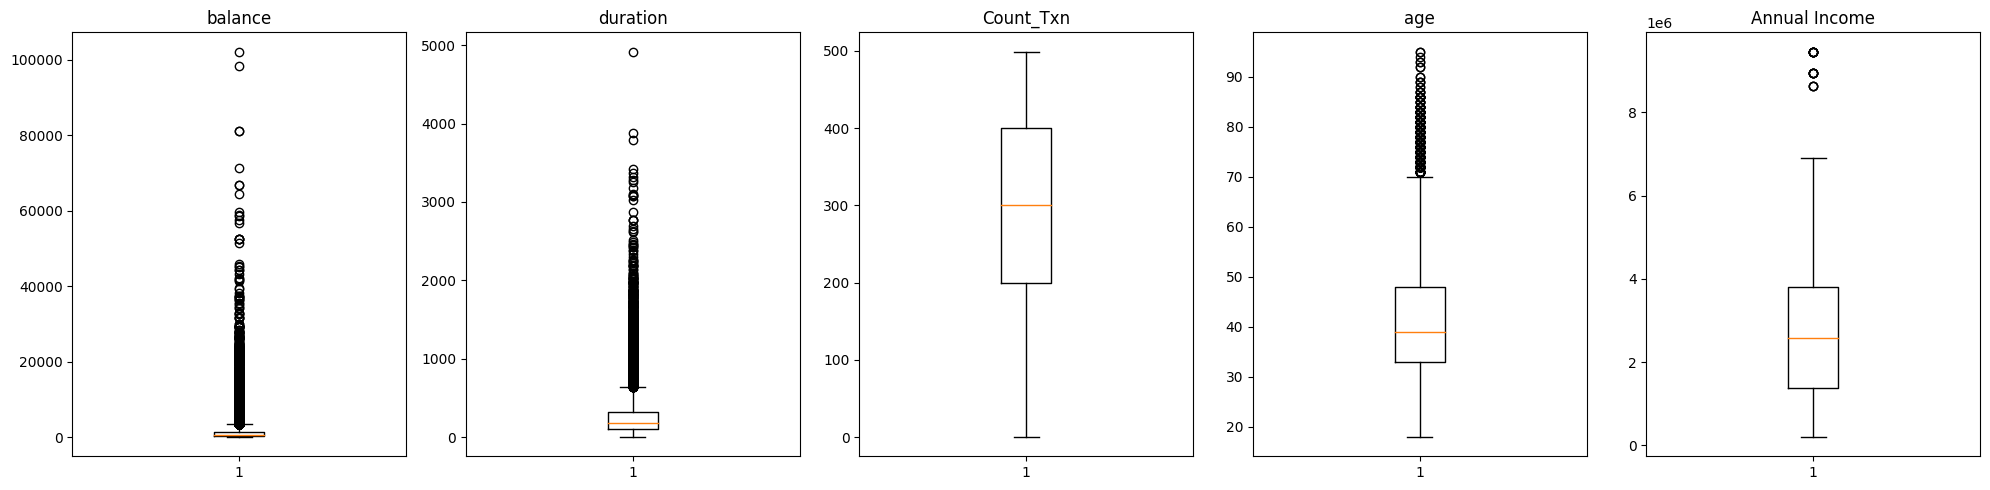

In [126]:
import matplotlib.pyplot as plt
numerical_columns = ['balance', 'duration', 'Count_Txn', 'age', 'Annual Income']

fig, axs = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(20, 5))

# Plotting boxplots for each numerical column
for i, column in enumerate(numerical_columns):
    axs[i].boxplot(df[column].dropna())
    axs[i].set_title(column)

plt.tight_layout()
plt.show()


As we can see except for Count_Txn every other column with missing values are filled with outliers. Hence we will be imputing them with median as mean is prone to outliers. As for Count_Txn we will be filling the missing values with mean

In [127]:
mean_columns = ['Count_Txn']
median_columns = ['age','balance', 'duration', 'Annual Income']

# Filling missing values with mean for 'Count_Txn'
for column in mean_columns:
    df[column].fillna(df[column].mean(), inplace=True)

# Fill missing values with median for 'balance','age', 'duration', and 'Annual Income'
for column in median_columns:
    df[column].fillna(df[column].median(), inplace=True)


In [128]:
df.isna().sum()  #All null values removed

Sno                 0
Customer_number     0
Insurance           0
balance             0
housing             0
loan                0
contact             0
duration            0
campaign            0
last_contact_day    0
previous            0
poutcome            0
Term Deposit        0
Count_Txn           0
age                 0
job                 0
marital             0
education           0
Annual Income       0
Gender              0
dtype: int64

*Checking for Imbalance in Target Data*

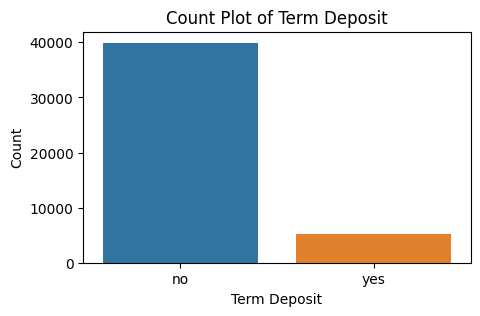

In [129]:
import seaborn as sns

# Plotting a count plot for 'Term Deposit'
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Term Deposit')
plt.title('Count Plot of Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Count')
plt.show()


*As this is so heavily imbalanced, we have to conduct undersampling on majority class*

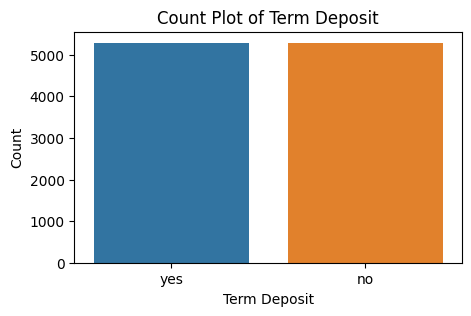

In [130]:
from imblearn.under_sampling import RandomUnderSampler

# Separating features and target variable
X = df.drop('Term Deposit', axis=1)  # Features
y = df['Term Deposit']  # Target variable


rus = RandomUnderSampler(sampling_strategy='majority')  # 'majority' will balance to the minority class

# Undersample the data
X_resampled, y_resampled = rus.fit_resample(X, y)


df = pd.concat([X_resampled, y_resampled], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Term Deposit')
plt.title('Count Plot of Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Count')
plt.show()

All the null values have been cleaned and Target feature are balanced.

###1. Term Deposit and Related Variables:
Identify variables strongly related to Term Deposit. Discuss your approach when the
variable is categorical. Which tests or metrics will you employ?

*So to understand the relevant features we will be performing some statistical test. To understand the relevancy of the Categorical Columns on Term Deposit we will be performing Chi Square Test for Independence of Attributes keeping in null hypothesis that the two relevant features are independent with level of significance as 0.05 ie we will keep the features whose p value is 0.05*

In [131]:
from scipy.stats import chi2_contingency

relevant_features=[]

# Extracting the categorical columns
categorical_cols = ['Insurance', 'housing', 'loan', 'contact', 'poutcome', 'job', 'marital', 'education', 'Gender']

for col in categorical_cols:
    contingency_table = pd.crosstab(df['Term Deposit'], df[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Chi-Square Test for ",col," vs Term Deposit:")
    print("Chi2 Statistic: ",chi2)
    print("P-value: ",p)
    print("")
    if p<0.05:
      relevant_features.append(col)

Chi-Square Test for  Insurance  vs Term Deposit:
Chi2 Statistic:  13.694188722669736
P-value:  0.00021511911859718212

Chi-Square Test for  housing  vs Term Deposit:
Chi2 Statistic:  497.0796955674958
P-value:  4.10556831830805e-110

Chi-Square Test for  loan  vs Term Deposit:
Chi2 Statistic:  150.46538683820782
P-value:  1.3716340618211388e-34

Chi-Square Test for  contact  vs Term Deposit:
Chi2 Statistic:  2.3335484681331407
P-value:  0.12661296262011804

Chi-Square Test for  poutcome  vs Term Deposit:
Chi2 Statistic:  927.7059892960066
P-value:  8.655987791861678e-201

Chi-Square Test for  job  vs Term Deposit:
Chi2 Statistic:  389.4523266327226
P-value:  1.651788965943256e-77

Chi-Square Test for  marital  vs Term Deposit:
Chi2 Statistic:  118.56268713289396
P-value:  1.7965512437856342e-26

Chi-Square Test for  education  vs Term Deposit:
Chi2 Statistic:  116.20898332472667
P-value:  5.828273148144551e-26

Chi-Square Test for  Gender  vs Term Deposit:
Chi2 Statistic:  0.1000179613

*For the Numerical columns we will be performing t-test where we divide the data in numerical column according to their corresponding Term Deposit class label. Then our null hypothesis stand as the mean of the data between these two classes is same under the level of significance of 0.05*

In [132]:
from scipy.stats import ttest_ind
# Perform t-test for numerical variables
numeric_cols = ['balance', 'duration', 'campaign', 'last_contact_day', 'previous', 'Count_Txn', 'age', 'Annual Income']

for col in numeric_cols:
    no_class = df[df['Term Deposit'] == 'no'][col]
    yes_class = df[df['Term Deposit'] == 'yes'][col]
    t_statistic, p_value = ttest_ind(no_class, yes_class)
    print("t-test for ",col," between 'no' and 'yes' classes: ")
    print("t-statistic: ",t_statistic)
    print("P-value: ",p_value)
    print("")
    if p_value<0.05:

      relevant_features.append(col)

t-test for  balance  between 'no' and 'yes' classes: 
t-statistic:  -8.541714243593077
P-value:  1.5040504234541934e-17

t-test for  duration  between 'no' and 'yes' classes: 
t-statistic:  -51.80215434994311
P-value:  0.0

t-test for  campaign  between 'no' and 'yes' classes: 
t-statistic:  13.915747242535117
P-value:  1.2312660988536873e-43

t-test for  last_contact_day  between 'no' and 'yes' classes: 
t-statistic:  -16.40212052229997
P-value:  1.0058149629627902e-59

t-test for  previous  between 'no' and 'yes' classes: 
t-statistic:  -15.006008201090037
P-value:  2.209701663213557e-50

t-test for  Count_Txn  between 'no' and 'yes' classes: 
t-statistic:  0.7082958130942235
P-value:  0.47877718669329195

t-test for  age  between 'no' and 'yes' classes: 
t-statistic:  -3.9498376426670005
P-value:  7.871180407558701e-05

t-test for  Annual Income  between 'no' and 'yes' classes: 
t-statistic:  0.7615232685874118
P-value:  0.44636156628717194



Checking for Multicollinearity among the Numerical Columns

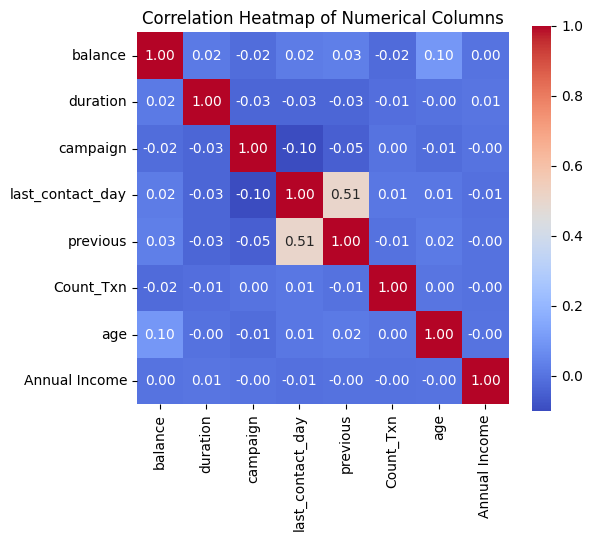

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ['balance', 'duration', 'campaign', 'last_contact_day', 'previous', 'Count_Txn', 'age', 'Annual Income']
numeric_data = df[numeric_columns]

#correlation matrix
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()


Since there is no Multicollinearity present we dont have to undergo measures such as PCA.

In [134]:
print("The Relevant Features that are significant on the target 'Term Deposit' are: \n",relevant_features)

The Relevant Features that are significant on the target 'Term Deposit' are: 
 ['Insurance', 'housing', 'loan', 'poutcome', 'job', 'marital', 'education', 'balance', 'duration', 'campaign', 'last_contact_day', 'previous', 'age']


###2. Predictive Model Building:
Train a prediction model of your choice to estimate the probability that a customer
will opt for a term deposit. Adhere to an 80:20 train:test split. Report and present
the model&#39;s performance metrics on both the train and test datasets.

In [135]:
df = df[relevant_features + ['Term Deposit']]

*Label Encoding the Categorical Columns*

In [136]:
from sklearn.preprocessing import LabelEncoder
# Encoding categorical variables
le = LabelEncoder()
categorical_columns = ['Insurance', 'housing', 'loan','poutcome', 'job', 'marital', 'education','Term Deposit']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

*Normal Scaling the Numerical Features to get all the data in a homogenous range*

In [137]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['balance', 'duration', 'campaign', 'last_contact_day', 'previous', 'age']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [138]:
df.head()

,Insurance,housing,loan,poutcome,job,marital,education,balance,duration,campaign,last_contact_day,previous,age,Term Deposit
0,0,1,0,0,9,1,1,0.205976,0.946048,-0.554014,-0.479948,-0.367062,0.757213,1
1,0,0,0,0,4,1,1,0.622331,-0.461970,0.552410,-0.479948,-0.367062,1.521127,0
2,0,1,1,0,1,1,0,-0.393879,-0.666773,-0.554014,-0.479948,-0.367062,-0.091579,0
3,0,0,0,0,5,1,1,-0.495753,-0.538771,0.183602,-0.479948,-0.367062,2.624557,1
4,0,1,1,1,9,2,1,-0.476770,-0.555838,-0.185206,1.737880,0.069942,0.078179,0


*Splitting the dataset in a 80-20 Ratio*

In [139]:
from sklearn.model_selection import train_test_split
# Features and Target variable
X = df.drop('Term Deposit', axis=1)
y = df['Term Deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Building the Model

*For building the model, we are using our base model as Naive Bayes, then we are implementing a Logistic Regression and followed by a Random Forest Classifier. Lastly we have done a competitive analysis*

In [203]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
preds_nb= naive_bayes.predict(X_test)
print('Train Score: ', naive_bayes.score(X_train, y_train))
print('Test Score: ' ,naive_bayes.score(X_test, y_test))
print("Classfication Report for Naive Bayes: \n",classification_report(y_test,preds_nb))

Train Score:  0.7380051997163791
Test Score:  0.7254253308128544
Classfication Report for Naive Bayes: 
               precision    recall  f1-score   support

           0       0.68      0.85      0.76      1068
           1       0.80      0.60      0.68      1048

    accuracy                           0.73      2116
   macro avg       0.74      0.72      0.72      2116
weighted avg       0.74      0.73      0.72      2116



In [204]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

preds_lr= logistic_reg.predict(X_test)
print('Train Score: ', logistic_reg.score(X_train, y_train))
print('Test Score: ' ,logistic_reg.score(X_test, y_test))
print("Classfication Report for Logistic Regression: \n",classification_report(y_test,preds_lr))

Train Score:  0.8072559678562987
Test Score:  0.7972589792060492
Classfication Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      1068
           1       0.82      0.75      0.79      1048

    accuracy                           0.80      2116
   macro avg       0.80      0.80      0.80      2116
weighted avg       0.80      0.80      0.80      2116



In [205]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

preds_rf= rf_classifier.predict(X_test)
print('Train Score: ', rf_classifier.score(X_train, y_train))
print('Test Score: ' ,rf_classifier.score(X_test, y_test))
print("Classfication Report for Random Forest: \n",classification_report(y_test,preds_rf))

Train Score:  1.0
Test Score:  0.8133270321361059
Classfication Report for Random Forest: 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1068
           1       0.80      0.83      0.81      1048

    accuracy                           0.81      2116
   macro avg       0.81      0.81      0.81      2116
weighted avg       0.81      0.81      0.81      2116



In [209]:
data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest'],
    'Train Accuracy': [naive_bayes.score(X_train, y_train), logistic_reg.score(X_train, y_train), rf_classifier.score(X_train, y_train)],
    'Test Accuracy': [naive_bayes.score(X_test, y_test), logistic_reg.score(X_test, y_test), rf_classifier.score(X_test, y_test)]
}

print("Comaparative Results: \n")
pd.DataFrame(data)

Comaparative Results: 



,Model,Train Accuracy,Test Accuracy
0,Naive Bayes,0.738005,0.725425
1,Logistic Regression,0.807256,0.797259
2,Random Forest,1.000000,0.813327


*Naive Bayes displays balanced and moderate accuracies, suggesting a reliable but less complex model. Logistic Regression performs slightly better, indicating a good fit to linear relationships. Random Forest excels in capturing intricate patterns, reflected in its high training accuracy. Its ability to generalize well is indicated by a comparable or slightly superior test accuracy despite its complexity, likely owing to its ensemble nature that prevents overfitting.*

###3. Model Improvement Strategies:
Discuss potential methods or approaches to enhance model performance.

1. *To improve the model we have decided to go for XGBOOST. It belongs to the ensemble learning methods family and utilizes a boosting technique, where multiple weak learners (decision trees) are combined to create a robust predictive model.*

In [216]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 2,                # Number of classes
    'max_depth': 3,                # Maximum depth of a tree
    'eta': 0.1,                    # Learning rate
    'eval_metric': 'merror'        # Evaluation metric
}


num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)
y_pred = xgb_model.predict(dtest)


train_accuracy = accuracy_score(y_train, xgb_model.predict(dtrain))
test_accuracy = accuracy_score(y_test, xgb_model.predict(dtest))

print('Train Score: ', train_accuracy)
print('Test Score: ' ,test_accuracy)
print("\nClassfication Report for XGBoost: \n",classification_report(y_test,y_pred))

Train Score:  0.8352635310801229
Test Score:  0.8293950850661626

Classfication Report for XGBoost: 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1068
           1       0.82      0.84      0.83      1048

    accuracy                           0.83      2116
   macro avg       0.83      0.83      0.83      2116
weighted avg       0.83      0.83      0.83      2116



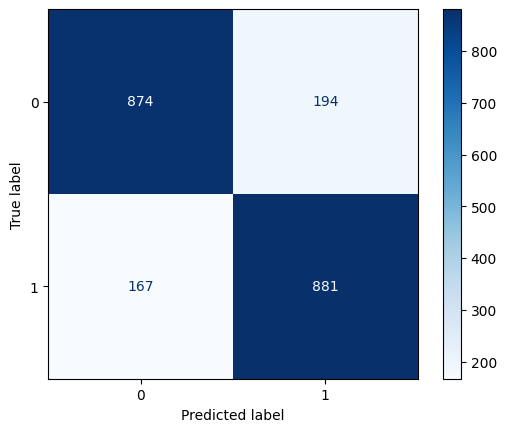

In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Conclusion:**

*The XGBoost model's increased accuracy to 83% can be attributed to its ensemble learning technique, which combines multiple decision trees to capture complex data patterns more effectively. Its adeptness at handling data intricacies and optimized hyperparameters allowed the model to better understand the dataset nuances, resulting in improved predictive performance.*